In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import metric, motif
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

In [2]:
# Parameters
window_size = 64
radiuses = np.linspace(0.1, 20.0, 200)
num_actions = 4

In [3]:
# Read subjects information
df = pd.read_csv('../motion-sense/data/data_subjects_info.csv', index_col=0)
display(df)

,weight,height,age,gender
code,,,,
1,102,188,46,1
2,72,180,28,1
3,48,161,28,0
4,90,176,31,1
5,48,164,23,0
6,76,180,28,1
7,62,175,30,0
8,52,161,24,0
9,93,190,32,1



subject = 24


HubFinder: 100%|█████████████████████████████████████████████████████████████████| 3875/3875 [00:02<00:00, 1731.72it/s]


[2909, 3952, 2267, 1067, 2131, 718, 3459, 2063, 3771, 256, 1696, 3140, 613, 2471, 942, 2674, 1294, 3384, 377, 2319, 2576, 2729, 1350, 1754, 2398, 3812, 2522, 993, 543, 22]


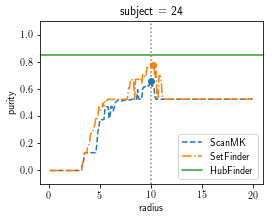

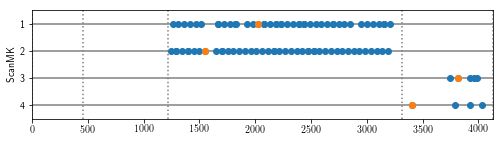

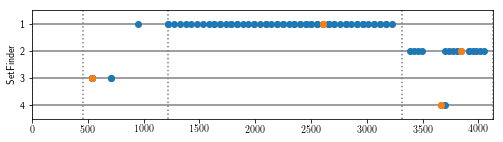

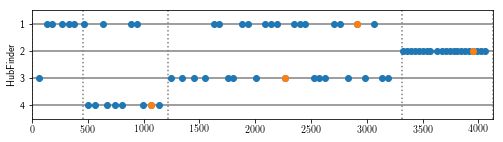

In [4]:
subjects = list(df.index)
activities = ['dws_11', 'ups_12', 'wlk_15', 'jog_16']

df['mk_purity'] = np.nan
df['mk_radius'] = np.nan
df['sf_purity'] = np.nan
df['sf_radius'] = np.nan
df['hf_purity'] = np.nan
mks = {}
sfs = {}
hfs = {}

# Compute purity for each subject
for subject in subjects:
# for subject in [24]:
    print('\nsubject =', subject)
    
    # Load time series
    Xs = []
    for activity in activities:
        filepath = '../motion-sense/data/B_Accelerometer_data/B_Accelerometer_data/{}/sub_{}.csv'.format(activity, subject)
        X = pd.read_csv(filepath, index_col=0).values
        Xs.append(X)
    
    # ScanMK
    mk = motif.ScanMK()
    mk.prepare(Xs, window_size)
    mk.scan()
    mks[subject] = mk
    
    # SetFinder
    sf = motif.SetFinder()
    sf.prepare(Xs, window_size)
    sf.count(radiuses)
    sfs[subject] = sf
    
    # HubFinder
    hf = motif.HubFinder()
    hf.compute(Xs, window_size)
    print(hf.motifs)
    hfs[subject] = hf
    
    # Set ground truth
    indices = hf.mp.indices
    actuals = []
    for i, length in enumerate(hf.mp.lengths):
        actuals.append(np.full(length - window_size + 1, i))
    actuals = np.concatenate(actuals)
    
    # Compute purity of ScanMK
    mk_purities = []
    for radius in radiuses:
        mk.find(radius)
        predictions = mk.get_nearest_labels(indices, num_motifs=4)
        purity = motif.get_purity(actuals, predictions)
        mk_purities.append(purity)
    mk_best_purity = np.max(mk_purities)
    mk_best_radius = radiuses[np.argmax(mk_purities)]
    df.loc[subject, 'mk_purity'] = mk_best_purity
    df.loc[subject, 'mk_radius'] = mk_best_radius
    mk.find(mk_best_radius)
    
    # Compute purity of SetFinder
    sf_purities = []
    for radius in radiuses:
        sf.find(radius)
        predictions = sf.get_nearest_labels(indices, num_motifs=4)
        purity = motif.get_purity(actuals, predictions)
        sf_purities.append(purity)
    sf_best_purity = np.max(sf_purities)
    sf_best_radius = radiuses[np.argmax(sf_purities)]
    df.loc[subject, 'sf_purity'] = sf_best_purity
    df.loc[subject, 'sf_radius'] = sf_best_radius
    sf.find(sf_best_radius)
    
    # Compute purity of HubFinder
    predictions = hf.get_nearest_labels(indices, num_motifs=4)
    hf_purity = motif.get_purity(actuals, predictions)
    df.loc[subject, 'hf_purity'] = hf_purity
    
    # Visualize radius vs purity
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.axvline(mk_best_radius, ls=':', c='0.5')
    ax.plot(radiuses, mk_purities, '--', c='tab:blue', label='ScanMK')
    ax.plot(radiuses, sf_purities, '-.', c='tab:orange', label='SetFinder')
    ax.plot(mk_best_radius, mk_best_purity, 'o', c='tab:blue')
    ax.plot(sf_best_radius, sf_best_purity, 'o', c='tab:orange')
    ax.axhline(hf_purity, ls='-', c='tab:green', label='HubFinder')
    ax.set_title('subject = {}'.format(subject))
    ax.set_xlabel('radius')
    ax.set_ylabel('purity')
    ax.set_ylim(-0.1, 1.1)
    ax.legend()
    plt.savefig('../figures/motion_{:g}.pdf'.format(subject), bbox_inches='tight')
    
    # Visualize motif labels
    mk.plot_labels(num_actions, xscale=0.002, yscale=0.5, ylabel='ScanMK', filename='../figures/motion_{:g}_mk.pdf'.format(subject))
    sf.plot_labels(num_actions, xscale=0.002, yscale=0.5, ylabel='SetFinder', filename='../figures/motion_{:g}_sf.pdf'.format(subject))
    hf.plot_labels(num_actions, xscale=0.002, yscale=0.5, ylabel='HubFinder', filename='../figures/motion_{:g}_hf.pdf'.format(subject))

# Save result
df.to_csv('result_motion.csv')

In [5]:
# Load result
df = pd.read_csv('result_motion.csv', index_col=0)
display(df)

,weight,height,age,gender,mk_purity,mk_radius,sf_purity,sf_radius,hf_purity
code,,,,,,,,,
1,102,188,46,1,NaN,NaN,NaN,NaN,NaN
2,72,180,28,1,NaN,NaN,NaN,NaN,NaN
3,48,161,28,0,NaN,NaN,NaN,NaN,NaN
4,90,176,31,1,NaN,NaN,NaN,NaN,NaN
5,48,164,23,0,NaN,NaN,NaN,NaN,NaN
6,76,180,28,1,NaN,NaN,NaN,NaN,NaN
7,62,175,30,0,NaN,NaN,NaN,NaN,NaN
8,52,161,24,0,NaN,NaN,NaN,NaN,NaN
9,93,190,32,1,NaN,NaN,NaN,NaN,NaN


0.1899354838709677
0.07354838709677414


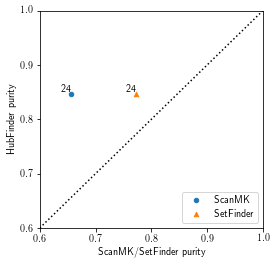

In [6]:
# Visualize purity comparison
fig, ax = plt.subplots(figsize=(4, 4))
df.plot.scatter('mk_purity', 'hf_purity', marker='o', c='tab:blue', label='ScanMK', ax=ax)
df.plot.scatter('sf_purity', 'hf_purity', marker='^', c='tab:orange', label='SetFinder', ax=ax)
ax.plot([0.6, 1], [0.6, 1], ':', c='k')
ax.set_xlim(0.6, 1)
ax.set_ylim(0.6, 1)
ax.set_xticks([0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
for i, (x, y) in enumerate(zip(df['mk_purity'], df['hf_purity'])):
    ax.annotate(str(i + 1), (x, y), horizontalalignment='right', verticalalignment='bottom')
for i, (x, y) in enumerate(zip(df['sf_purity'], df['hf_purity'])):
    ax.annotate(str(i + 1), (x, y), horizontalalignment='right', verticalalignment='bottom')
ax.set_xlabel('ScanMK/SetFinder purity')
ax.set_ylabel('HubFinder purity')
ax.legend(loc='lower right')
plt.savefig('../figures/motion_scatter.pdf', bbox_inches='tight', pad_inches=0)
print(df['hf_purity'].mean() - df['mk_purity'].mean())
print(df['hf_purity'].mean() - df['sf_purity'].mean())


subject = 5


HubFinder: 100%|█████████████████████████████████████████████████████████████████| 4661/4661 [00:04<00:00, 1128.74it/s]


[3909, 4739, 576, 3024, 637, 1096, 1048, 1219, 2277, 4617, 1495, 4056, 1833, 4200, 1456, 2826, 167, 2515, 3254, 2616, 4261, 3444, 43, 1743, 3721, 3486, 2978, 420]


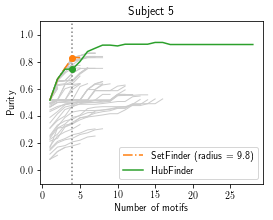

In [7]:
# Examine subject 5 (HubFinderr vs SetFinder)
subject = 5
print('\nsubject =', subject)

# Load time series
Xs = []
for activity in activities:
    filepath = '../motion-sense/data/B_Accelerometer_data/B_Accelerometer_data/{}/sub_{}.csv'.format(activity, subject)
    X = pd.read_csv(filepath, index_col=0).values
    Xs.append(X)

# SetFinder
sf = motif.SetFinder()
sf.prepare(Xs, window_size)
sf.count(radiuses)

# HubFinder
hf = motif.HubFinder()
hf.compute(Xs, window_size)
print(hf.motifs)

# Set ground truth
indices = hf.mp.indices
actuals = []
for i, length in enumerate(hf.mp.lengths):
    actuals.append(np.full(length - window_size + 1, i))
actuals = np.concatenate(actuals)

# Compute purity of SetFinder
sf_purities = {}
for radius in radiuses:
    sf.find(radius)
    if len(sf.motifs) > 0:
        purities = [np.nan]
        for num_motifs in range(1, len(sf.motifs) + 1):
            predictions = sf.get_nearest_labels(indices, num_motifs)
            purity = motif.get_purity(actuals, predictions)
            purities.append(purity)
        sf_purities[radius] = purities
sf_best_purity = -1.0
sf_best_radius = None
for radius, purities in sf_purities.items():
    try:
        purity = purities[num_actions]
        if purity > sf_best_purity:
            sf_best_purity = purity
            sf_best_radius = radius
    except IndexError:
        continue

# Compute purity of HubFinder
hf_purities = [np.nan]
for num_motifs in range(1, len(hf.motifs) + 1):
    predictions = hf.get_nearest_labels(indices, num_motifs)
    purity = motif.get_purity(actuals, predictions)
    hf_purities.append(purity)
    
# Visualize #motifs vs purity
fig, ax = plt.subplots(figsize=(4, 3))
for radius in radiuses:
    try:
        ax.plot(sf_purities[radius], lw=1, c='0.8')
    except KeyError:
        continue
ax.axvline(num_actions, ls=':', c='0.5')
ax.plot(sf_purities[sf_best_radius], '-.', c='tab:orange', label='SetFinder (radius = {:g})'.format(sf_best_radius))
ax.plot(hf_purities, '-', c='tab:green', label='HubFinder')
ax.plot(num_actions, sf_purities[sf_best_radius][num_actions], 'o', c='tab:orange')
ax.plot(num_actions, hf_purities[num_actions], 'o', c='tab:green')
ax.set_xlabel('Number of motifs')
ax.set_ylabel('Purity')
ax.set_ylim(-0.1, 1.1)
ax.set_title('Subject {}'.format(subject))
ax.legend()
plt.savefig('../figures/motion_{}_motif_vs_purity.pdf'.format(subject), bbox_inches='tight', pad_inches=0)

In [8]:
# Examine subject 23
subject = 23
print('\nsubject =', subject)

# Load time series
Xs = []
for activity in activities:
    filepath = '../motion-sense/data/B_Accelerometer_data/B_Accelerometer_data/{}/sub_{}.csv'.format(activity, subject)
    X = pd.read_csv(filepath, index_col=0).values
    Xs.append(X)

# ScanMK
mk = motif.ScanMK()
mk.prepare(Xs, window_size)
mk.scan()

# SetFinder
sf = motif.SetFinder()
sf.prepare(Xs, window_size)
sf.count(radiuses)

# HubFinder
hf = motif.HubFinder()
hf.compute(Xs, window_size)
print(hf.motifs)

# Set ground truth
indices = hf.mp.indices
actuals = []
for i, length in enumerate(hf.mp.lengths):
    actuals.append(np.full(length - window_size + 1, i))
actuals = np.concatenate(actuals)

# Set best radius for ScanMK
mk_purities = []
for radius in radiuses:
    mk.find(radius)
    predictions = mk.get_nearest_labels(indices, num_motifs=4)
    purity = motif.get_purity(actuals, predictions)
    mk_purities.append(purity)
mk_best_purity = np.max(mk_purities)
mk_best_radius = radiuses[np.argmax(mk_purities)]
mk.find(mk_best_radius)

# Set best radius for SetFinder
sf_purities = []
for radius in radiuses:
    sf.find(radius)
    predictions = sf.get_nearest_labels(indices, num_motifs=4)
    purity = motif.get_purity(actuals, predictions)
    sf_purities.append(purity)
sf_best_purity = np.max(sf_purities)
sf_best_radius = radiuses[np.argmax(sf_purities)]
sf.find(sf_best_radius)


subject = 23


HubFinder: 100%|█████████████████████████████████████████████████████████████████| 6887/6887 [00:05<00:00, 1174.51it/s]


[4533, 6306, 2480, 966, 4295, 2312, 6796, 5815, 3098, 1234, 1016, 5316, 6999, 0, 624, 2725, 6829, 2000, 4452, 888, 807, 6072, 6191, 486, 4376, 3681, 1782, 3273, 2873, 5199, 1585, 1686, 6348, 3618, 742, 3437, 3937, 2253, 4055, 2411, 1170, 665, 224]


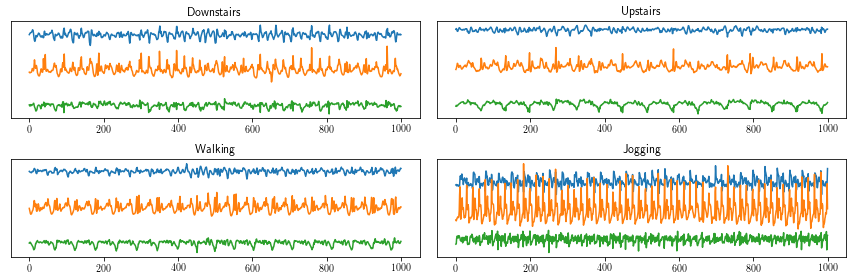

In [9]:
# Visualize time series
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 4))
axes[0][0].set_title('Downstairs')
axes[0][0].plot(Xs[0][:1000, 0])
axes[0][0].plot(Xs[0][:1000, 1] - 5)
axes[0][0].plot(Xs[0][:1000, 2] - 8)
axes[0][0].set_yticks([])
axes[0][1].set_title('Upstairs')
axes[0][1].plot(Xs[1][:1000, 0])
axes[0][1].plot(Xs[1][:1000, 1] - 5)
axes[0][1].plot(Xs[1][:1000, 2] - 8)
axes[0][1].set_yticks([])
axes[1][0].set_title('Walking')
axes[1][0].plot(Xs[2][:1000, 0])
axes[1][0].plot(Xs[2][:1000, 1] - 5)
axes[1][0].plot(Xs[2][:1000, 2] - 8)
axes[1][0].set_yticks([])
axes[1][1].set_title('Jogging')
axes[1][1].plot(Xs[3][:1000, 0])
axes[1][1].plot(Xs[3][:1000, 1] - 5)
axes[1][1].plot(Xs[3][:1000, 2] - 8)
axes[1][1].set_yticks([])
plt.tight_layout()
plt.show()

ScanMK


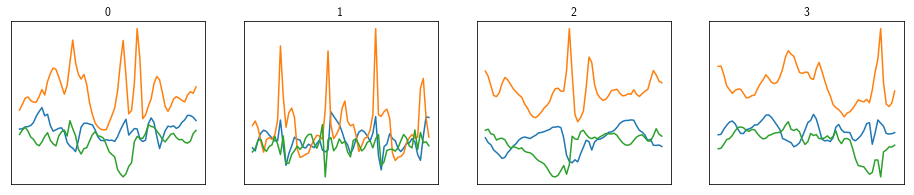

SetFinder


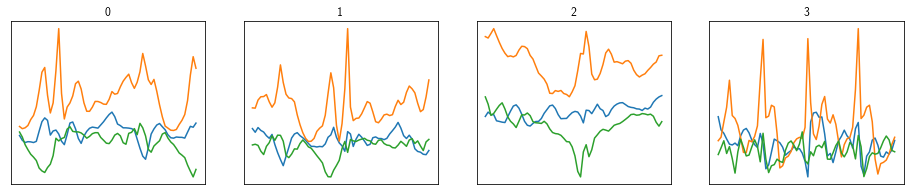

HubFinder


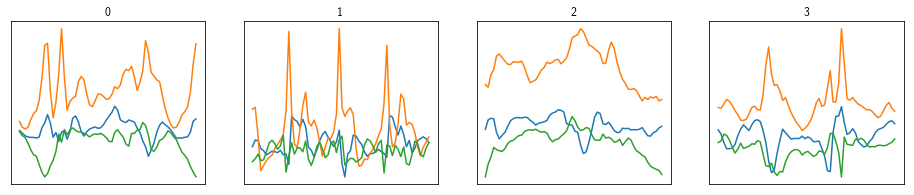

In [10]:
# Visualize ScanMK motifs
print('ScanMK')
fig, axes = plt.subplots(ncols=num_actions, figsize=(4 * num_actions, 3))
for i, subsequence in enumerate(mk.mp.get_subsequences(mk.motifs[:num_actions])):
    axes[i].plot(subsequence[:, 0])
    axes[i].plot(subsequence[:, 1])
    axes[i].plot(subsequence[:, 2])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(str(i))
plt.show()

# Visualize SetFinder motifs
print('SetFinder')
fig, axes = plt.subplots(ncols=num_actions, figsize=(4 * num_actions, 3))
for i, subsequence in enumerate(sf.mp.get_subsequences(sf.motifs[:num_actions])):
    axes[i].plot(subsequence[:, 0])
    axes[i].plot(subsequence[:, 1])
    axes[i].plot(subsequence[:, 2])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(str(i))
plt.show()

# Visualize HubFinder motifs
print('HubFinder')
fig, axes = plt.subplots(ncols=num_actions, figsize=(4 * num_actions, 3))
for i, subsequence in enumerate(hf.mp.get_subsequences(hf.motifs[:num_actions])):
    axes[i].plot(subsequence[:, 0])
    axes[i].plot(subsequence[:, 1])
    axes[i].plot(subsequence[:, 2])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(str(i))
plt.show()